# Ego lane detection notebook

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob

The pipeline of lane detection is as follows:
2. Convert RGB to Grayscale.
2. Reduce noise using a Gaussian filter.
3. Canny edge detector. Computes gradient in all directions of the blurred image. Traces the edges with large changes in intesity. 
4. Place a mask to only keep pixels corresponding to the road (Region of Interest).
5. Hough Line Transform. A transform that detects straight lines. The Probabilistic Hough Line Transform is used here, which gives output as the extremes of the detected lines. 
6. Post-process the detected lines to compute ego lane. 

The functions that we need are found in [lane_detection.py](./lane_detection.py). In this notebook, we go through the steps one by one and see their effect on a number of test images.

#### Original images

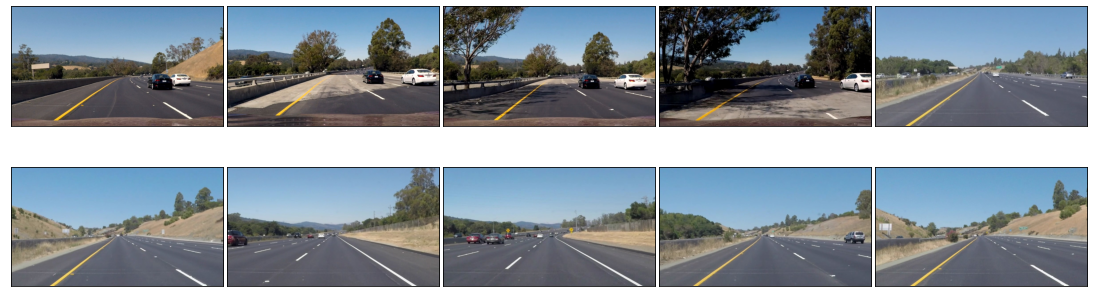

In [2]:
test_images = [plt.imread(path) for path in glob.glob('../data/test_images/*.jpg')]
cols = 5
rows = (len(test_images)+1)//cols

plt.figure(figsize=(15, 5))
for i, image in enumerate(test_images):
    plt.subplot(rows, cols, i+1)
    plt.imshow(image, cmap=None)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

#### Color selection
As a preprocessing step we can try to filter colors of interest

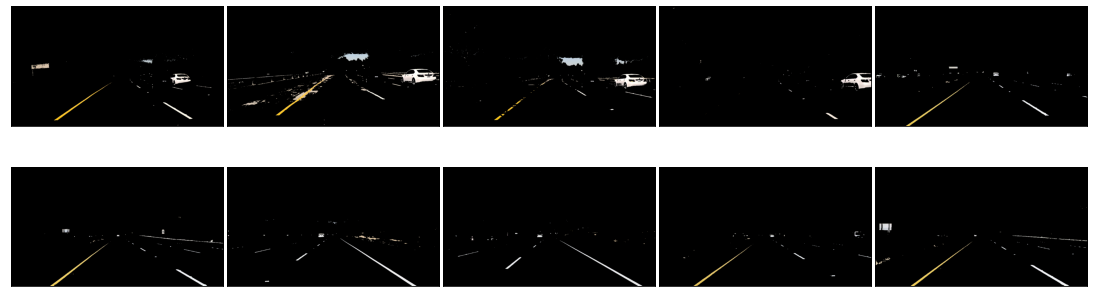

In [3]:
from lane_detection import selectWhiteYellow

plt.figure(figsize=(15, 5))
for i, image in enumerate(test_images):
    plt.subplot(rows, cols, i+1)
    maskedWhiteYellow = selectWhiteYellow(image, space = 'RGB')
    plt.imshow(maskedWhiteYellow, cmap=None)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

Looks like it picks up the lanes pretty well! Except for one image where yellow is under shade (row 1, col 4).

#### HSV and HSL Color Spaces
Another preprocessing step is to try different color spaces, i.e., transform the image from RGB to another space. Two common ones are HSV and HSL. First try HSV.

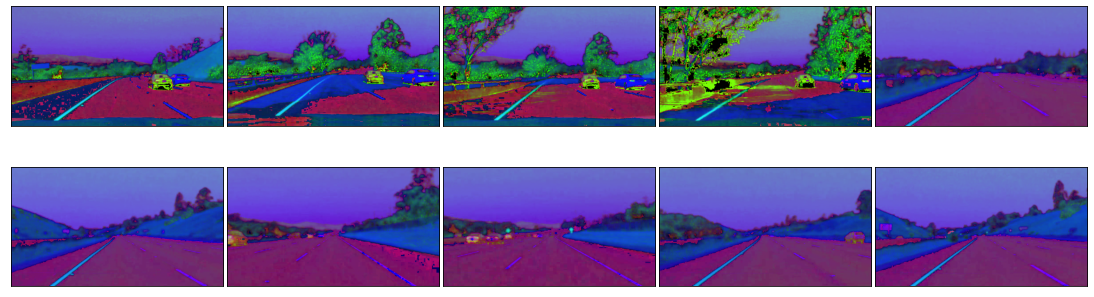

In [4]:
plt.figure(figsize=(15, 5))
for i, image in enumerate(test_images):
    plt.subplot(rows, cols, i+1)
    imageHSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    plt.imshow(imageHSV, cmap=None)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

This works better with shaded regions, but is a bit weaker in (row 2, col 2 & 3). Now try HSL.

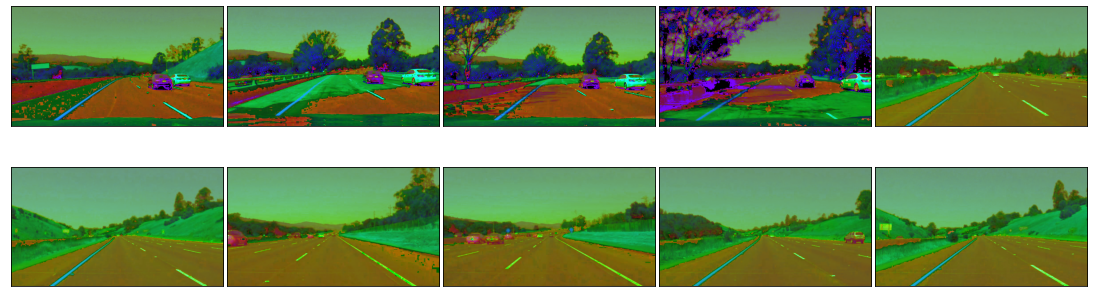

In [5]:
plt.figure(figsize=(15, 5))
for i, image in enumerate(test_images):
    plt.subplot(rows, cols, i+1)
    imageHSL = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    plt.imshow(imageHSL, cmap=None)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

This looks pretty clear as well in most cases. Now let's combine color space transformation with selecting white and yellow colors as before.

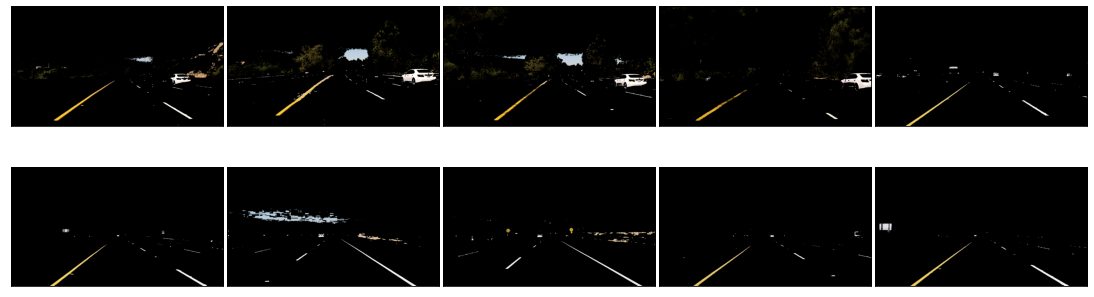

In [6]:
from lane_detection import selectWhiteYellow

plt.figure(figsize=(15, 5))
for i, image in enumerate(test_images):
    plt.subplot(rows, cols, i+1)
    maskedWhiteYellow = selectWhiteYellow(image, space = 'HSL')
    plt.imshow(maskedWhiteYellow, cmap=None)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

We got the best out of both worlds now!

#### Canny Edge Detection
To perform Canny Edge Detection we first convert the image to grayscale, then filter out noise by using a Gaussian filter, and finally call the edge detector. Below we repeat computations to show all the intermediate transformations.

##### Convert to grayscale

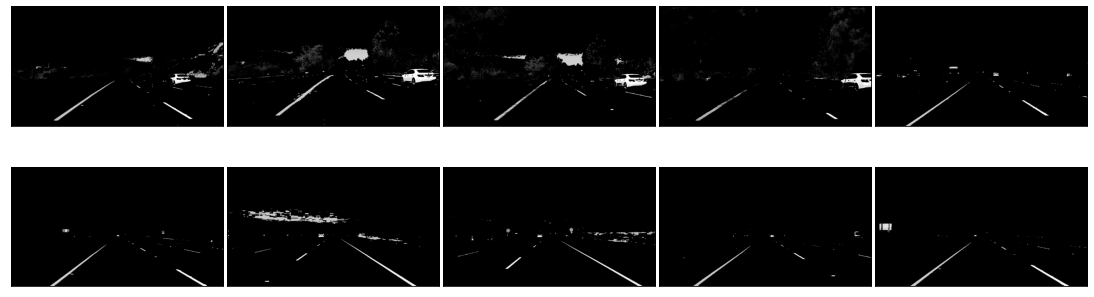

In [7]:
from lane_detection import selectWhiteYellow

plt.figure(figsize=(15, 5))
for i, image in enumerate(test_images):
    plt.subplot(rows, cols, i+1)
    maskedWhiteYellow = selectWhiteYellow(image, space = 'HSL')
    grayscaled = cv2.cvtColor(maskedWhiteYellow, cv2.COLOR_RGB2GRAY) 
    plt.imshow(grayscaled, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

##### Gaussian blurring

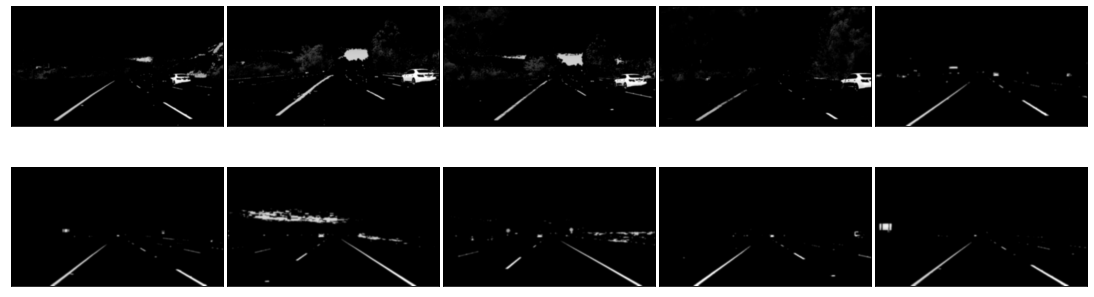

In [8]:
from lane_detection import selectWhiteYellow

plt.figure(figsize=(15, 5))
for i, image in enumerate(test_images):
    plt.subplot(rows, cols, i+1)
    maskedWhiteYellow = selectWhiteYellow(image, space = 'HSL')
    grayscaled = cv2.cvtColor(maskedWhiteYellow, cv2.COLOR_RGB2GRAY)
    kernelSize = 15 # must be postivie and odd
    blurred = cv2.GaussianBlur(grayscaled, (kernelSize, kernelSize), 0) 
    plt.imshow(blurred, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

##### Edge detection
We want to keep edges with high gradients. If a pixel gradient is higher than the upper threshold, the pixel is accepted as an edge. If a pixel gradient value is below the lower threshold, it is rejected. If the pixel gradient is between the two thresholds, then it is accepted only if it is connected to a pixel that is above the upper threshold (weak acceptance). 

Canny recommended a ratio between 2:1 and 3:1 for the upper and lower bounds, but need to find the values by trial and error. 

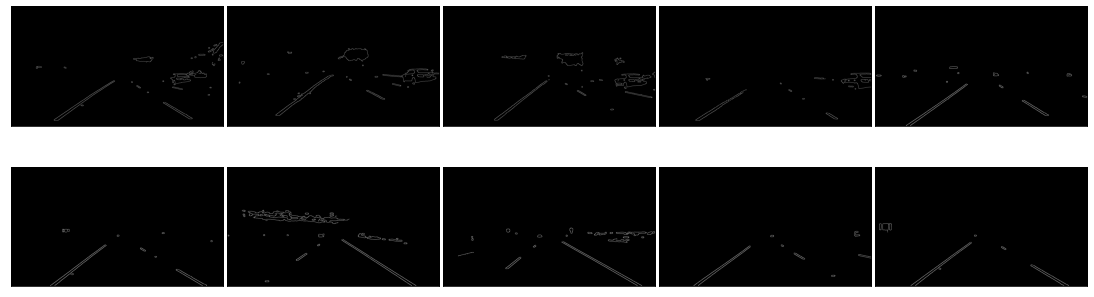

In [9]:
from lane_detection import selectWhiteYellow

plt.figure(figsize=(15, 5))
for i, image in enumerate(test_images):
    plt.subplot(rows, cols, i+1)
    maskedWhiteYellow = selectWhiteYellow(image, space = 'HSL')
    grayscaled = cv2.cvtColor(maskedWhiteYellow, cv2.COLOR_RGB2GRAY)
    kernelSize = 15 # must be postivie and odd
    blurred = cv2.GaussianBlur(grayscaled, (kernelSize, kernelSize), 0)
    upper_thresh = 150
    lower_thresh = 50
    canny = cv2.Canny(blurred, lower_thresh, upper_thresh)
    plt.imshow(canny, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

#### Region of interest

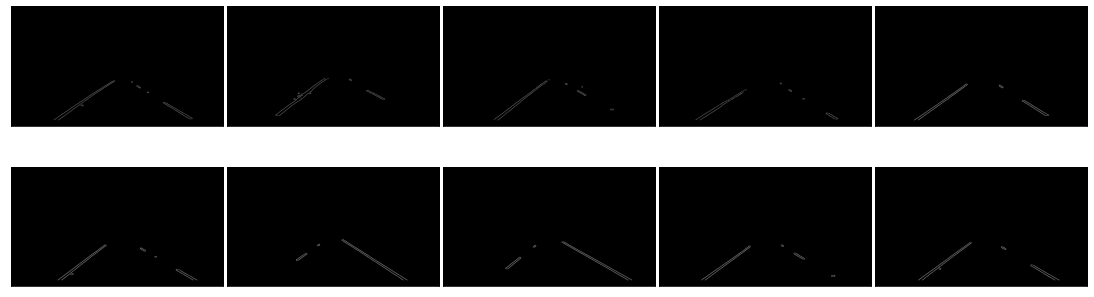

In [10]:
from lane_detection import selectWhiteYellow, getRegionOfInterest

plt.figure(figsize=(15, 5))
for i, image in enumerate(test_images):
    plt.subplot(rows, cols, i+1)
    maskedWhiteYellow = selectWhiteYellow(image, space = 'HSL')
    grayscaled = cv2.cvtColor(maskedWhiteYellow, cv2.COLOR_RGB2GRAY)
    kernelSize = 15 # must be postivie and odd
    blurred = cv2.GaussianBlur(grayscaled, (kernelSize, kernelSize), 0)
    upper_thresh = 150
    lower_thresh = 50
    canny = cv2.Canny(blurred, lower_thresh, upper_thresh)
    roiImage = getRegionOfInterest(canny)
    plt.imshow(roiImage, cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

#### Hough Line Transform

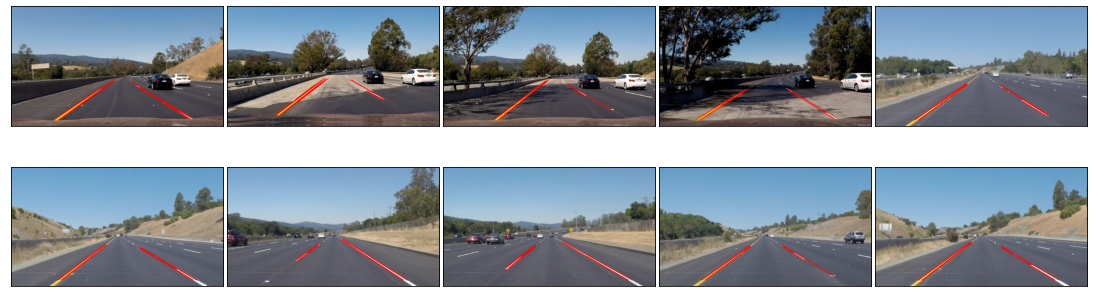

In [14]:
from lane_detection import selectWhiteYellow, getRegionOfInterest, drawLines

plt.figure(figsize=(15, 5))
for i, image in enumerate(test_images):
    plt.subplot(rows, cols, i+1)
    maskedWhiteYellow = selectWhiteYellow(image, space = 'HSL')
    grayscaled = cv2.cvtColor(maskedWhiteYellow, cv2.COLOR_RGB2GRAY)
    kernelSize = 15 # must be postivie and odd
    blurred = cv2.GaussianBlur(grayscaled, (kernelSize, kernelSize), 0)
    upper_thresh = 150
    lower_thresh = 50
    canny = cv2.Canny(blurred, lower_thresh, upper_thresh)
    roiImage = getRegionOfInterest(canny)
    lines = cv2.HoughLinesP(roiImage, rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=300)
    overlaidImage = drawLines(image, lines)
    plt.imshow(overlaidImage, cmap=None)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

#### Averaging and extrapolating
There are multiple lines detected for a lane line. Some lane lines are only partially recognized. We should extrapolate the line to cover full lane line length. We are looking to return one left line and one right line for our lane. 

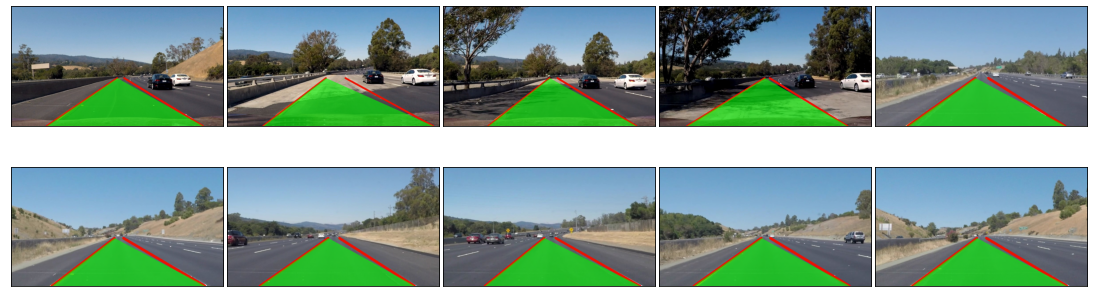

In [3]:
from lane_detection import selectWhiteYellow, getRegionOfInterest, average_slope_intercept, plotDetectedEgoLane

plt.figure(figsize=(15, 5))
for i, image in enumerate(test_images):
    plt.subplot(rows, cols, i+1)
    maskedWhiteYellow = selectWhiteYellow(image, space = 'HSL')
    grayscaled = cv2.cvtColor(maskedWhiteYellow, cv2.COLOR_RGB2GRAY)
    kernelSize = 15 # must be postivie and odd
    blurred = cv2.GaussianBlur(grayscaled, (kernelSize, kernelSize), 0)
    upper_thresh = 150
    lower_thresh = 50
    canny = cv2.Canny(blurred, lower_thresh, upper_thresh)
    roiImage = getRegionOfInterest(canny)
    lines = cv2.HoughLinesP(roiImage, rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=300)
    leftLane, rightLane = average_slope_intercept(image, lines)
    overlaidImage = plotDetectedEgoLane(image, leftLane, rightLane)
    plt.imshow(overlaidImage, cmap=None)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

The above procedure is found in [lane_detection.py](./lane_detection.py), which can also be called to perform lane detection on a video:
```
python lane_detection.py --input_file path-to-video.mp4
```